In [1]:
#!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-06-30 16:52:11--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  3.72MB/s    in 0.9s    

2023-06-30 16:52:18 (3.72 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
dfraw = pd.read_csv('AirlineTweets.csv')
print (dfraw.columns)
print (dfraw.shape)
dfraw.head()

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df = dfraw[['airline_sentiment', 'text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

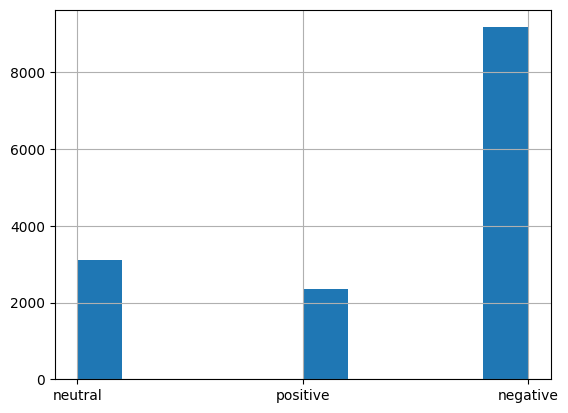

In [6]:
df['airline_sentiment'].hist()

In [7]:
target_map = {'negative': 0, 'neutral': 2, 'positive': 1}
df['target'] = df.airline_sentiment.map(target_map)

df2 = df[['text', 'target']].copy()
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=False)
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [8]:
from datasets import load_dataset, load_metric
raw_dataset = load_dataset('csv', data_files='data.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/przemek/.cache/huggingface/datasets/csv/default-1fb476f64262ffaa/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [9]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [10]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

In [11]:
from transformers import AutoTokenizer
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True)
tokenized_datasets = split.map(tokenize_function, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [22]:
from transformers import AutoModelForSequenceClassification, AutoConfig, \
    Trainer, TrainingArguments

In [23]:
config = AutoConfig.from_pretrained(checkpoint)
print (config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.30.2",
  "vocab_size": 28996
}



In [24]:
print (f'{config.id2label = }')
print (f'{config.label2id = }')


config.id2label = {0: 'LABEL_0', 1: 'LABEL_1'}
config.label2id = {'LABEL_0': 0, 'LABEL_1': 1}


In [25]:
config.id2label = {v:k for k,v in target_map.items()}
config.label2id = target_map
print (f'{config.id2label = }')
print (f'{config.label2id = }')

config.id2label = {0: 'negative', 2: 'neutral', 1: 'positive'}
config.label2id = {'negative': 0, 'neutral': 2, 'positive': 1}


In [26]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    config=config)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.w

In [27]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [28]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

In [29]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(y_true=labels, y_pred=predictions),
        'f1': f1_score(y_true=labels, y_pred=predictions, average='macro')
    }

In [30]:
trainer = Trainer(
    model, 
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [31]:
trainer.train()

/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.427253,0.834927,0.781204
2,0.447700,0.443873,0.840619,0.791657
3,0.447700,0.523582,0.841302,0.794753


/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/przemek/anaconda3/envs/hf/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=963, training_loss=0.3347026076272269, metrics={'train_runtime': 128.2824, 'train_samples_per_second': 239.659, 'train_steps_per_second': 7.507, 'total_flos': 416215849457376.0, 'train_loss': 0.3347026076272269, 'epoch': 3.0})

In [32]:
!ls training_dir

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-321	checkpoint-642	checkpoint-963


In [33]:
from transformers import pipeline
savemodel = pipeline('text-classification', model='training_dir/checkpoint-963', device=0)

In [34]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [46]:
test_pred = savemodel(split['test']['sentence'])
print (len(test_pred))
test_pred[0]

4392


{'label': 'positive', 'score': 0.9573110938072205}

In [47]:
test_pred = [target_map[x['label']] for x in test_pred]

In [48]:
print ("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8413023679417122


In [49]:
print ("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7947533049785797


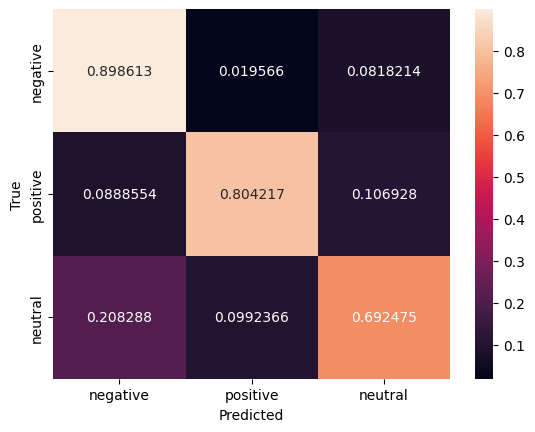

In [50]:
def plot_cm(cm):
    classes = ['negative', 'positive', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    
cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)